# A Brief Introduction to Lindsey's Method

### Timothy Daley

Lindsey's methods is a technique for nonparametric density estimation for exponential families.  I first encountered it in Efron's book *Large-Scale Inference* [link](https://efron.ckirby.su.domains/other/2010LSIexcerpt.pdf), though the technique originates from [Construction and Comparison of Statistical Models](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1974.tb01015.x).  

Suppose we want to fit a continuous $J$-parameter exponential family to one-dimensional data,
$$
f(x) = \exp \bigg( \sum_{j=1}^{J} \beta_{j} x^{j} \bigg).
$$
If the data is only positive, then $J$ can be odd or even, but if the data is both positive and negative then $J$ has to be even to ensure the density integrates to 1.   

The trick of Lindsey's method is convert the difficult problem of general exponential family density estimation into Poisson regression through binning.  Suppose you bin your data into $K$ bins of equal width $d$.  Define $y_{k} = \sum_{i=1}^{N} 1(x_{i} \in k \text{th bin})$. If we define $m_{k}$ as the midpoint of the $k$th bin, then $y_{k}$ is Poisson distributed with expected value 
$$ 
\mathrm{E} y_{k} = N d f(m_{k}).
$$

Why would we want to use Lindsey's method, when standard methods would be better.  One, is that we can use a large polynomial to fit a high parameter exponential family to allow us some flexibility in fitting models.  Two, is that we can fit a distribution to just part of the observed data.  Efron's application was to fit a high parameter exponential family to the central peak.  His goal was to identify outliers using the local fdr on tail observation by comparing the empirical distribution to the expected distribution from fitting the central peak under the two groups assumption (see my previous post [2 groups](https://timydaley.github.io/twoGroupsBackground.html)).  

My use of Lindsey's method was to fit the null distribution of CRISPR guide RNAs in a large pooled screen.  I did not find that Lindsey's method worked well for this application because the null distribution tail was too long.  Instead I used a skewed $t$ distribution.   

Here, I'll show with code how to use Lindsey's method, using and [old notebook](file:///Users/timothydaley/Downloads/LindseysMethod.html) as a guide.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm

In [2]:
housing=pd.read_csv('housing.csv')
print(housing.shape)
housing.head(3)

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


<Axes: xlabel='median_income', ylabel='Count'>

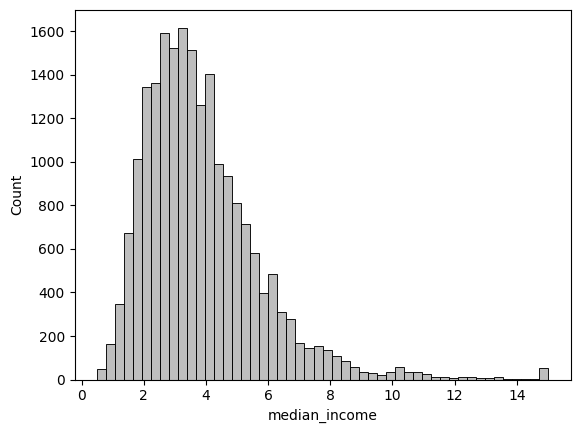

In [3]:
seaborn.histplot(x='median_income', data=housing, color='darkgrey', bins=50)

In [4]:
y=housing['median_income']
sum(y==max(y))

49

In [5]:
# seems like the data is truncated from above.  That will affect our estimates, so let's remove them
y=y[y != max(y)]

<Axes: xlabel='median_income', ylabel='Count'>

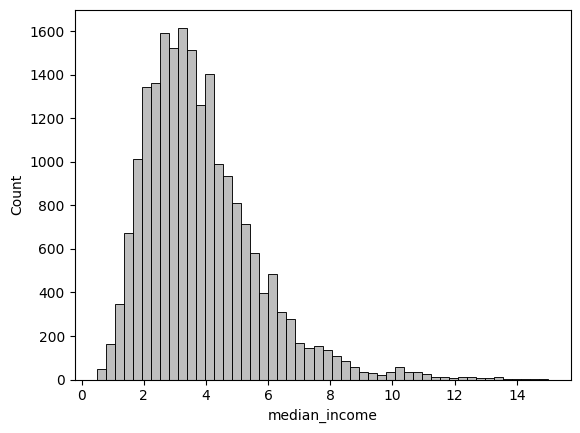

In [6]:
seaborn.histplot(x=y, color='darkgrey', bins=50)

In [7]:
def bin_data(x, n_bins):
    bins=np.linspace(min(x)-1, max(x)+1, num=n_bins)
    midpoints=np.zeros(len(bins)-1)
    hist_counts=np.zeros(len(bins)-1)
    for i in range(len(midpoints)):
        midpoints[i]=(bins[i]+bins[i+1])/2.0
        hist_counts[i]=sum((y >= bins[i]) & (y < bins[i+1]))
    return bins, midpoints, hist_counts

bins, midpoints, hist_counts = bin_data(y, 50)
N=sum(hist_counts)
d=bins[1]-bins[0]
# check if counts are correct
print(sum(hist_counts) == len(y))

True


In [8]:
# R has built in poly() function to produce polynomials of data, 
# for python we need to build that manually
def raw_poly(x, p):
    x = np.array(x)
    X = np.transpose(np.vstack([x**k for k in range(1, p+1)]))
    return X
    
# checking output against R output
test= [1, 2, 3]
raw_poly(test, 2)

array([[1, 1],
       [2, 4],
       [3, 9]])

In [9]:
exog=raw_poly(midpoints, 4)
exog=sm.add_constant(exog)
income_4param_lindsey =sm.GLM(hist_counts, exog, family=sm.families.Poisson())
income_4param_lindsey_res = income_4param_lindsey.fit()
income_4param_lindsey_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:                            GLM   Df Residuals:                       44
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -351.20
Date:                Sun, 03 Dec 2023   Deviance:                       414.40
Time:                        17:36:33   Pearson chi2:                     405.
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7326      0.070     39.030      0.000       2.595       2.870
x1             3.7192      0.063     58.658      0.000       3.595       3.843
x2            -0.9258      0.019    -48.062      0.000      -0.964      -0.888
x3             0.0819      0.002     35.569      0.000       0.077       0.086
x4            -0.0025   9.25e-05    -27.452      0.000      -0.003      -0.002
==============================================================================
"""

One thing I do need to mention here is that if you intend to use the fit in regions outside the input data, then the parameters have to be checked because the highest order parameter needs to be negative to ensure that the density is proper.  

In [10]:
def poisson_glm_pdf(params, poly_x, N, d):
    poly_part=np.sum(np.multiply(poly_x, params[1:]))
    return np.exp(poly_part + params[0] - (np.log(N) + np.log(d)))

In [11]:
def get_lindsey_distribution(params, exog, N, d):
    poly_x=pd.DataFrame(exog)
    poly_x.drop(columns=poly_x.columns[0], axis=1, inplace=True)
    return poly_x.apply(lambda x: poisson_glm_pdf(params, x, N, d), axis=1)

income_4param_lindsey_dist=get_lindsey_distribution(income_4param_lindsey_res.params, exog, N, d)

<Axes: xlabel='median_income', ylabel='Density'>

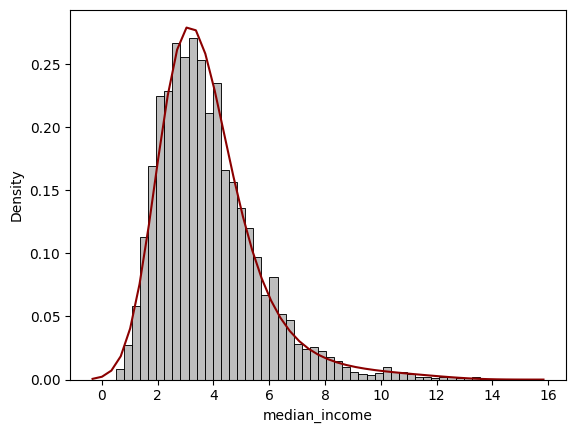

In [12]:
ax=seaborn.histplot(y, color='darkgrey', bins=50, stat='density')
seaborn.lineplot(x=midpoints, y=income_4param_lindsey_dist, ax=ax, color='darkred')

What if we fit a 2 parameter exponential model, aka a normal distribution?  Let's compare Lindsey's method to the standard normal fit. 

In [13]:
exog=raw_poly(midpoints, 2)
exog=sm.add_constant(exog)
income_2param_lindsey =sm.GLM(hist_counts, exog, family=sm.families.Poisson())
income_2param_lindsey_res = income_2param_lindsey.fit()
income_2param_lindsey_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:                            GLM   Df Residuals:                       46
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2610.8
Date:                Sun, 03 Dec 2023   Deviance:                       4933.7
Time:                        17:36:33   Pearson chi2:                 3.34e+05
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2993      0.026    207.463      0.000       5.249       5.349
x1             1.0562      0.013     80.540      0.000       1.030       1.082
x2            -0.1395      0.002    -88.555      0.000      -0.143      -0.136
==============================================================================
"""

In [14]:
from scipy.stats import norm
mu, std = norm.fit(y)
print("mu: ", mu, " std: ", std)

mu:  3.844186518381817  std:  1.8227116310328035


<Axes: xlabel='median_income', ylabel='Density'>

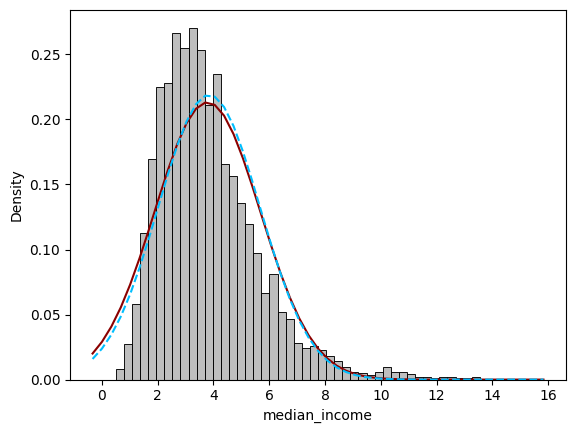

In [15]:
income_2param_lindsey_dist=get_lindsey_distribution(income_2param_lindsey_res.params, exog, N, d)
norm_fit = norm.pdf(midpoints, mu, std)
ax=seaborn.histplot(y, color='darkgrey', bins=50, stat='density')
seaborn.lineplot(x=midpoints, y=income_2param_lindsey_dist, ax=ax, color='darkred')
seaborn.lineplot(x=midpoints, y=norm_fit, ax=ax, color='deepskyblue', linestyle='--')

The match of the Lindsey estimate of the normal fit is pretty close to the actual.  The Poissonization adds variance to the estimate, that might want to be avoided.  However, for the 3+ parameter cases, fitting the standard MLE not trivial and Lindsey's method provides a quick and easy way to obtain fits.  